### Playground IT2TSK Triangular

In [64]:
from notebook_resolver import *
from src.utils.pandas_extension import *
from src.dataset import Dataset, WorkSheet

dataset_path = "data/e-nose_dataset_12_beef_cuts.xlsx"

dataset = Dataset(
	path=dataset_path, sheet_name=WorkSheet.DS10.value,
)

train_df = dataset.train_df
test_df = dataset.validate_df


In [73]:
from sklearn.metrics import r2_score
from src.pipeline import Pipeline
from src.pipelines.transformers import FeatureScaler, Clusterer
from src.pipelines.predictors import IT2TskPredictor
from src.fis.fuzzy_logic.mfs import MFType2
from src.fis.fuzzy_logic.consequents import LinearModel
from src.clusters import ClusteringMethod

target_column = 'TVC'

transformer_pipe = Pipeline(steps=[
	('feature_scaler', FeatureScaler(decimal_places=4)),
	('clusterer', Clusterer(method=ClusteringMethod.FUZZY_C_MEANS)),
])

transformer_pipe.fit(train_df)
transformed_df = transformer_pipe.transform(train_df)
clusters = transformer_pipe.named_steps['clusterer'].clusters

predictor_pipe = Pipeline(steps=[
	('predictor', IT2TskPredictor(target=target_column))
])

predictor_pipe.fit(
    transformed_df,
	predictor__mf_type=MFType2.TRIANGULAR,
    predictor__linear_model=LinearModel.LSE,
    predictor__clusters=clusters
)

transformed_test_df = transformer_pipe.transform(test_df)
X_test_df = transformed_test_df.drop(columns=[target_column])

y_test_ = transformed_test_df[target_column].values
y_pred_ = predictor_pipe.predict(X_test_df)

r2 = r2_score(y_test_, y_pred_)
print(f"R2 Score on Test Data: {r2}")

R2 Score on Test Data: 0.8932755508568256


In [74]:
predictor = predictor_pipe.named_steps['predictor']

In [75]:
predictor.get_lt_rules()

+--------+-----------+------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Rule   | Cluster   | IF (Antecedents)                         | THEN (Consequents)                                                                                                                                                       |
+========+===========+==========================================+==========================================================================================================================================================================+
| Rule 1 | Cluster 0 | MQ135 is High AND MQ136 is Low AND MQ137 | TVC is 0.4587 + 0.107*MQ135 + -1.0814*MQ136 + 0.3363*MQ137 + 1.0905*MQ138 + 0.2037*MQ2 + 0.6971*MQ3 + -1.0365*MQ4 + 0.0897*MQ5 + -0.0026*MQ6 + -0.0297*MQ8 + -0.0149*MQ9 |
|        |           | is High AND MQ138 is Low AND 

,Rule,Cluster,IF (Antecedents),THEN (Consequents)
0,Rule 1,Cluster 0,MQ135 is High AND MQ136 is Low AND MQ137 is Hi...,TVC is 0.4587 + 0.107*MQ135 + -1.0814*MQ136 + ...
1,Rule 2,Cluster 1,MQ135 is High AND MQ136 is High AND MQ137 is L...,TVC is 0.567 + 0.0097*MQ135 + -0.2423*MQ136 + ...


In [76]:
clusters.get_execution_time_stats('_create_mfs_clusters')

{'count': 1,
 'total_time': 1.9156392498407513,
 'average_time': 1.9156392498407513,
 'min_time': 1.9156392498407513,
 'max_time': 1.9156392498407513}

In [77]:
clusters.get_execution_time_stats('_create_rules_cluster')

{'count': 1,
 'total_time': 0.6569711670745164,
 'average_time': 0.6569711670745164,
 'min_time': 0.6569711670745164,
 'max_time': 0.6569711670745164}

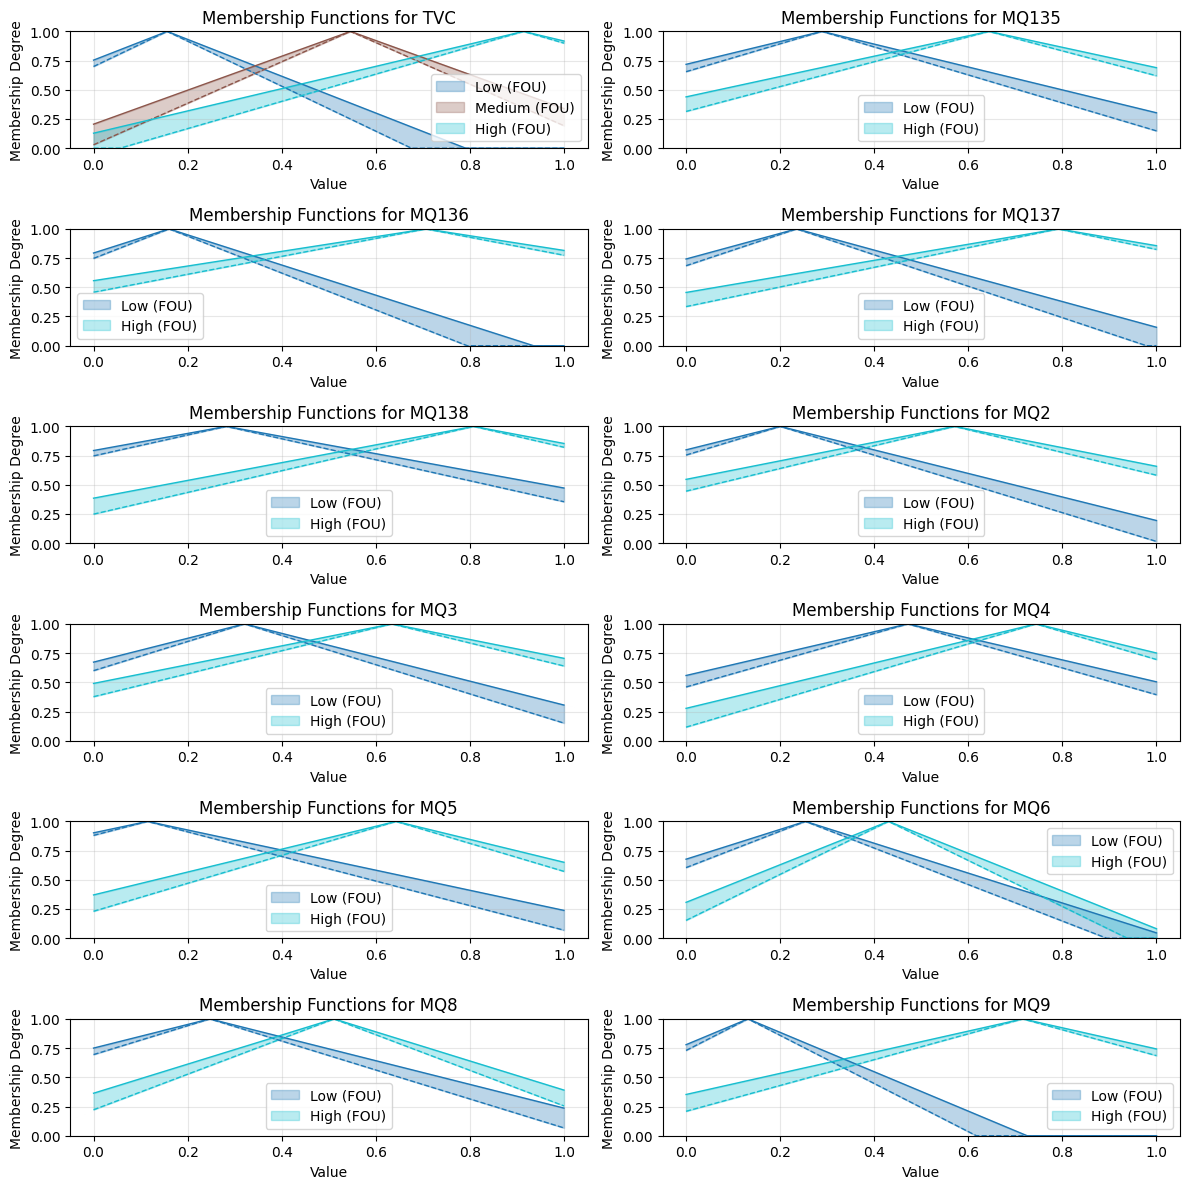

In [78]:
predictor.plot_mfs_grid()

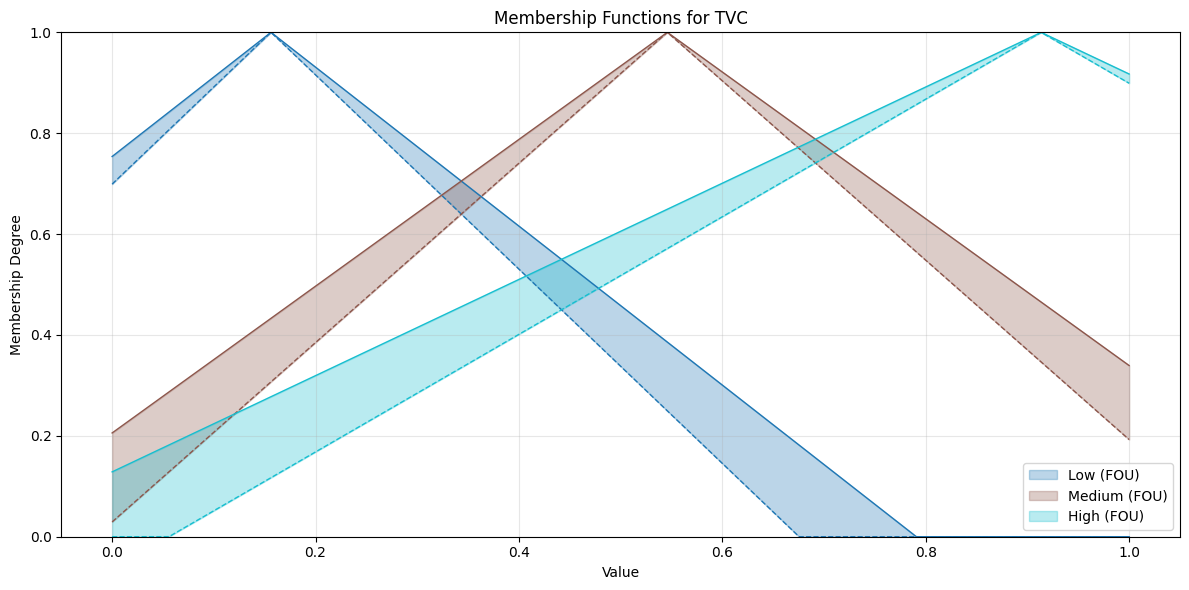

In [79]:
predictor.plot_mf('TVC')

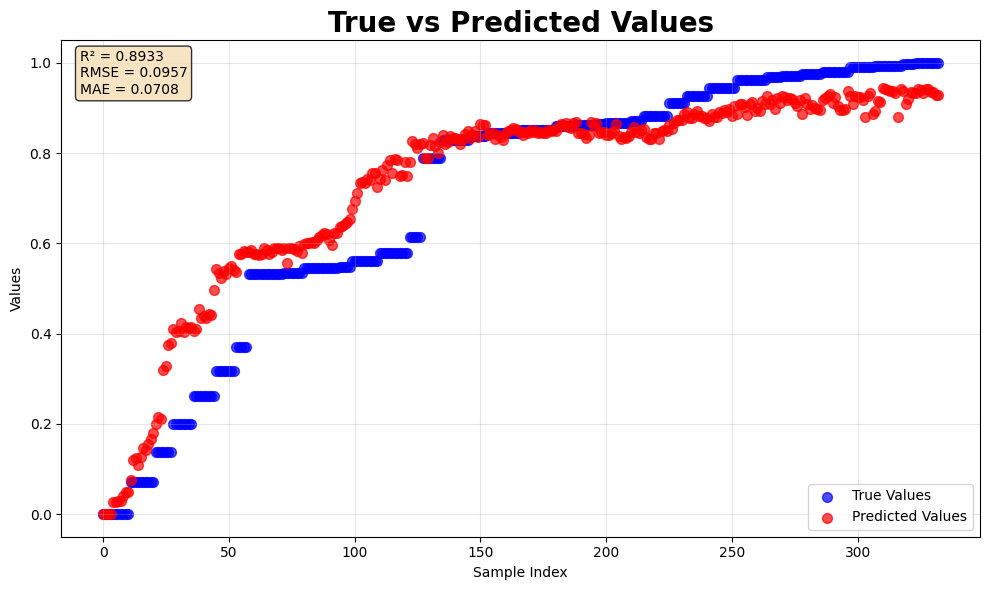

In [80]:
predictor.plot_true_vs_pred(y_test_, y_pred_)